# Cross validation

Batchflow allows to perform cross validation. By the `cv_split` method of `Dataset` one can divide dataset into folds and then realize arbitrary logic. Additional functional of `Research` allows to to perform the simplest variant of cross validation. We also demonstrate how to work with `torch` models and `Research`

In [1]:
import sys
import tensorflow as torch

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../..")
from batchflow import Pipeline, Dataset, B, C, V
from batchflow.opensets import MNIST
from batchflow.models.torch import VGG7
from batchflow.research import Research, Option

To split dataset into `n` folds one just need call `cv_split` method and define `n_splits`:

In [2]:
dset = Dataset(10)
dset.cv_split(n_splits=4)
dset.cv0.train.indices, dset.cv0.test.indices

(array([3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2]))

## Cross validation in `Research`

One can implement cross validation to estimate the quality of the model in the following way.

In [3]:
BATCH_SIZE=64

Define model config.

In [4]:
model_config={
    'inputs': dict(images={'shape': (1, 28, 28)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'initial_block/inputs': 'images',
    'body/block/layout': 'cna',
    'device': C('device') # it's technical parameter for TFModel and TorchModel
}

Define dataset that will be used in the training procedure. We take training part of the MNIST dataset to use it for CV.

In [5]:
mnist = MNIST().train

Extracting /tmp/train-images-idx3-ubyte.gz
ExtractingExtracting /tmp/t10k-images-idx3-ubyte.gz
 /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


Now define main parts of pipelines (without datasets):

In [6]:
train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_variable('accuracy', init_on_each_run=list)
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array(channels='first', dtype='float32')
            .train_model('conv', B('images'), B('labels'),
                         fetches='loss',
                         save_to=V('loss'), mode='w')
).run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)

In [7]:
test_template = (Pipeline()
            .init_variable('predictions') 
            .init_variable('metrics', init_on_each_run=None) 
            .import_model('conv', C('import_from'))
            .to_array(channels='first', dtype='float32')
            .predict_model('conv', B('images'), B('labels'),
                         fetches='predictions',
                         save_to=V('predictions'))
            .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics'), mode='a')
).run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True)

### Create Research object

Create an instance of `Research` class and add train and test pipelines and grid of parameters:

In [8]:
def get_accuracy(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    metrics = pipeline.get_variable('metrics')
    return metrics.evaluate('accuracy')

research = (Research()
            .add_pipeline(train_template, dataset=mnist, part='train', variables='loss', name='train')
            .add_pipeline(test_template, dataset=mnist, part='test', name='test',
                      execute='%50', run=True, import_from='train')
            .add_function(get_accuracy, returns='accuracy', name='test_accuracy',
                      execute='%50', pipeline='test')

)

Dataset should be added as a separate parameter into research, parameter `part` describe part of the dataset to use with the pipeline. It means that for dataset `mnist`, pipeline `ppl` and fold `train` for each fold of CV (for example, for `cv0`) will be created pipeline `mnist.cv0.train.p + ppl`. 

Method `run` has parameter `n_splits` which describes the number of folds. Note that to allow `Research` to parallelize training of torch models, we define parameter `framework='torch'`. In that case we `device='cuda:i'` into model config instead of `device='/device:GPU:i'` for Tensorflow model.

In [9]:
research.run(workers=4, n_iters=1000, gpu=[4,5,6,7], n_splits=5, name='my_research', progress_bar=True, framework='torch')

Research my_research is starting...


  0%|          | 0/5000 [00:00<?, ?it/s]

Distributor has 5 jobs with 1000 iterations. Totally: 5000


100%|██████████| 5000/5000 [03:40<00:00, 22.64it/s]


In [10]:
results = research.load_results()
results.head()

,accuracy,cv_split,iteration,loss,name,repetition
0,NaN,0,0,2.496154,train,0
1,NaN,0,1,2.317913,train,0
2,NaN,0,2,2.166673,train,0
3,NaN,0,3,2.331690,train,0
4,NaN,0,4,2.242133,train,0


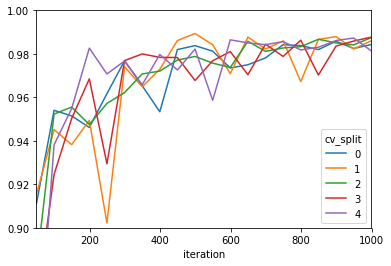

In [11]:
(results[(results.name == 'test_accuracy')]
 .pivot(index='iteration', columns='cv_split', values='accuracy')
 .plot(ylim=(0.9, 1))
)